In [2]:
import os
import ast
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras import optimizers
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization
from keras.models import Sequential
from keras import backend as K

print(os.listdir("data"))

['test_simplified.csv', 'train_simplified.zip', 'train_simplified']


### helper function

* convert data points to images
* needs to be optimized for higher quality of images


In [3]:
dim = (200, 200) #image dimension

# datapoint to image conversion
def draw_to_img(datapoints):

    images = []
    i =0
    for data in datapoints:
        #stroke = ast.literal_eval(stroke)
        fig, ax = plt.subplots()
        
        for x,y in data:
            ax.invert_yaxis()
            ax.plot(x, y, linewidth=12)
            ax.axis('off')
        #render figure
        fig.canvas.draw()
        
        X = np.array(fig.canvas.renderer._renderer)
        plt.close("all")
        plt.clf()
        
        # resize, normalize and invert the image
        X = (cv2.resize(X, dim) / 255.)[::-1]
        # channels
        X = X[:, :, 3]
            
        print('processed {}/{}'.format(i+1,len(datapoints)),end = '\r', flush=True)
        i+=1
        plt.close(fig)
        images.append(X)
            
    print("\n")
    print ('Finished!')  
    images_conv = np.array(images)    
    return images_conv


# grayscale to rgb conversion
def to_rgb(img):
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb

# plot model results using this function
def plot_metrics_primary(acc, val_acc, loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(20,7))

    ax1.plot(acc, label='Train Accuracy')
    ax1.plot(val_acc, label='Validation accuracy')
    ax1.legend(loc='best')
    ax1.set_title('Accuracy')

    ax2.plot(loss, label='Train loss')
    ax2.plot(val_loss, label='Validation loss')
    ax2.legend(loc='best')
    ax2.set_title('Loss')
    plt.xlabel('Epochs')

In [4]:
TRAIN_PATH = "data/train_simplified/"
TEST_PATH = "data/test_simplified.csv"
SUBMISSION_NAME = 'submission.csv'

* go the each csv file in training 
* read nrwos of data from all of the csv files in the train_simplified
* set nrows to **None** to get **all** the data from **all** csv files in the train_simplified folder


In [94]:
train = pd.DataFrame()
for file in os.listdir(TRAIN_PATH):
    train = train.append(pd.read_csv(TRAIN_PATH + file, usecols=[1, 5], nrows=1))
    
#shuffle the training data
#train = shuffle(train, random_state=123)

In [95]:
# set nrows = None for all the datapoints
test = pd.read_csv(TEST_PATH, usecols=[0, 2], nrows=100) # was 100 before

In [96]:
# total number of classes
len(os.listdir(TRAIN_PATH))

340

In [97]:
len(train), len(test)

(340, 100)

In [98]:
# Model parameters
LEARNING_RATE = 0.001
N_CLASSES = train['word'].nunique() #number of classes
CHANNEL = 1

print(N_CLASSES)

340


In [87]:
# fixing label in the training set
train['word'] = train['word'].replace(' ', '_', regex=True)

# get labels and one-hot encode them.
classes_names = train['word'].unique()
labels = pd.get_dummies(train['word']).values
train.drop(['word'], axis=1, inplace=True)
len(labels)

340

In [88]:
#print(classes_names)

In [89]:
print(labels[100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


In [90]:
#  training datapoints stacked in a list
drawings_train = [ast.literal_eval(pts) for pts in train['drawing'].values]
len(drawings_train)

340

In [14]:
train_images = draw_to_img(drawings_train)

processed 340/340

Finished!


<Figure size 432x288 with 0 Axes>

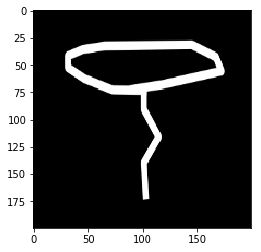

In [20]:
plt.imshow(train_images[0], cmap=plt.cm.binary_r)

In [100]:
#  testing datapoints stacked in a list
drawings_test = [ast.literal_eval(pts) for pts in test['drawing'].values]
len(drawings_test)

100

In [101]:
test_images = draw_to_img(drawings_test)

processed 100/100

Finished!


<Figure size 432x288 with 0 Axes>

In [24]:
train_images.shape, test_images.shape

((340, 200, 200), (100, 200, 200))

### Split data in train and validation (90% ~ 10%)

In [25]:
x_train, x_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1, random_state=1)

Train and valididation sets

In [26]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((306, 200, 200), (306, 340), (34, 200, 200), (34, 340))

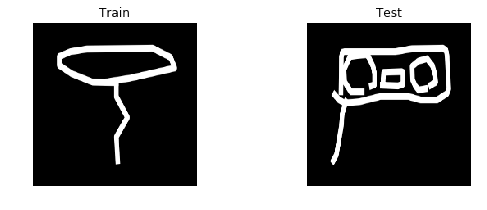

In [102]:
img_train = train_images[0]
img_test = test_images[0]

plt.figure(figsize=(9, 3));
plt.subplot(1, 2, 1); plt.title('Train'); plt.axis('off');
plt.imshow(img_train, cmap='gray');
plt.subplot(1, 2, 2); plt.title('Test'); plt.axis('off');
plt.imshow(img_test, cmap='gray');

In [28]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((306, 200, 200), (306, 340), (34, 200, 200), (34, 340))

### FINAL MODEL PIPELINE UP TO THIS!

### Model

In [38]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


batch_size = 64
num_classes = N_CLASSES
epochs = 4
# dim = (200, 200) #image dimension
img_rows, img_cols = 200, 200

In [39]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [40]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

x_train /= 255
x_val /= 255

print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)

print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')

x_train shape: (306, 200, 200, 1)
x_val shape: (34, 200, 200, 1)
306 train samples
34 test samples


In [41]:
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)

In [42]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(306, 200, 200, 1) (306, 340) (34, 200, 200, 1) (34, 340)


In [43]:
print(x_train[5].shape)

(200, 200, 1)


In [44]:
#y_train[0]
print(input_shape)

(200, 200, 1)


In [45]:
# refer to https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

'''
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
metrics=['accuracy'])

model.summary()

'''

"\nmodel = Sequential()\nmodel.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))\nmodel.add(Conv2D(64, (3, 3), activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\nmodel.add(Flatten())\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(num_classes, activation='softmax'))\n\nmodel.compile(loss=keras.losses.categorical_crossentropy,\n              optimizer=keras.optimizers.Adadelta(),\nmetrics=['accuracy'])\n\nmodel.summary()\n\n"

In [46]:
def get_model():
    
    input_layer=Input(shape=(img_rows, img_cols, 1))
    
    x=Conv2D(filters=8,kernel_size=(5,5),padding='valid', activation='relu')(input_layer)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=16,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=32,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    #x=Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu')(x)
    #x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    #x=Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu')(x)
    #x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    #x=Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu')(x)
    #x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    x=Flatten()(x)
    
    x=Dense(units=64)(x)
    x=Dense(units=N_CLASSES)(x) 
    
    output_layer=Activation('softmax')(x)
    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adadelta')
    return model

model=get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 8)       208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 32)        0         
__________

In [ ]:
'''
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))
#score = model.evaluate(x_test, y_test, verbose=0)


'''

In [47]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(306, 200, 200, 1) (306, 340) (34, 200, 200, 1) (34, 340)


In [48]:
path_model='quickdraw_cnn.h5' 

#K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=get_model() 
#K.set_value(model.optimizer.lr,1e-3) # set the learning rate

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=64, 
            epochs=10,
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 306 samples, validate on 34 samples
Epoch 1/10
306/306 [==============================] - 10s 32ms/step - loss: 5.8308 - acc: 0.0000e+00 - val_loss: 5.8346 - val_acc: 0.0000e+00
Epoch 2/10
306/306 [==============================] - 8s 27ms/step - loss: 5.8296 - acc: 0.0000e+00 - val_loss: 5.8407 - val_acc: 0.0000e+00
Epoch 3/10
306/306 [==============================] - 8s 27ms/step - loss: 5.8289 - acc: 0.0000e+00 - val_loss: 5.8472 - val_acc: 0.0000e+00
Epoch 4/10
306/306 [==============================] - 8s 28ms/step - loss: 5.8282 - acc: 0.0033 - val_loss: 5.8539 - val_acc: 0.0000e+00
Epoch 5/10
306/306 [==============================] - 8s 27ms/step - loss: 5.8275 - acc: 0.0000e+00 - val_loss: 5.8609 - val_acc: 0.0000e+00
Epoch 6/10
306/306 [==============================] - 8s 27ms/step - loss: 5.8268 - acc: 0.0000e+00 - val_loss: 5.8678 - val_acc: 0.0000e+00
Epoch 7/10
306/306 [==============================] - 8s 27ms/step - loss: 5.8260 - acc: 0.0033 - val_loss: 5.87

### Test model

In [ ]:
# Transform drawing into numpy arrays
#test['drawing_np'] = test['drawing'].apply(drawing_to_np)
# Reshape arrays
#test_drawings = np.asarray([x.reshape(HEIGHT, WIDTH, CHANNEL) for x in test['drawing_np'].values])

In [ ]:
#test_drawings.shape

In [56]:
'''
dim = (48, 48)
imgs_list_test = []

for img in range(len(test_images)):
    image = cv2.resize(test_images[img], dim, interpolation = cv2.INTER_AREA)
    image_arr = np.asarray(np.dstack((image, image, image)), dtype=np.uint8)
    imgs_list_test.append(image_arr)
    
rgb_arr = np.stack([imgs_list_test],axis=4)
test_3d = np.squeeze(rgb_arr, axis=4)

test_3d.shape

'''

'\ndim = (48, 48)\nimgs_list_test = []\n\nfor img in range(len(test_images)):\n    image = cv2.resize(test_images[img], dim, interpolation = cv2.INTER_AREA)\n    image_arr = np.asarray(np.dstack((image, image, image)), dtype=np.uint8)\n    imgs_list_test.append(image_arr)\n    \nrgb_arr = np.stack([imgs_list_test],axis=4)\ntest_3d = np.squeeze(rgb_arr, axis=4)\n\ntest_3d.shape\n\n'

In [61]:
if K.image_data_format() == 'channels_first':
    test_images = test_images.reshape(test_images.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [62]:
test_images_re = test_images.astype('float32')
test_images_re /= 255

print(test_images_new.shape)

(100, 200, 200, 1)


In [63]:
test_images.shape

(100, 200, 200, 1)

In [77]:
#make predictions
predictions = model.predict(test_images_new)

In [73]:
x = np.argpartition(predictions[5], -3)[-3:]
print(x)

[269  69 251]


In [74]:
top_3_predictions = np.asarray([np.argpartition(pred, -3)[-3:] for pred in predictions])
top_3_predictions = ['%s %s %s' % (classes_names[pred[0]], classes_names[pred[1]], classes_names[pred[2]]) for pred in top_3_predictions]
test['word'] = top_3_predictions

In [75]:
len(top_3_predictions)
print(top_3_predictions[5])

crocodile spoon animal_migration


In [76]:
submission = test[['key_id', 'word']]
submission.to_csv(SUBMISSION_NAME, index=False)
submission.head()

,key_id,word
0,9000003627287624,lipstick spoon animal_migration
1,9000010688666847,crocodile spoon animal_migration
2,9000023642890129,crocodile spoon animal_migration
3,9000038588854897,lipstick spoon animal_migration
4,9000052667981386,butterfly animal_migration spoon
